# VicRoads Crash Data - Classification with Logistic Regression and Trees

---

This tutorial explores the fitting of logistic regression, including regularisaion, and classification trees for the VicRoads Crash Data. We also discuss how to evaluate classification models.

<table align="left">
  <td>
    <a href="https://colab.research.google.com/github/OpenActTextDev/ActuarialRegression/blob/main/Notebooks/VicRoadCrashLrTree.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>
  </td>
</table>

## The VicRoads Crash Data

The  dataset consists of real road crashes in Victoria, Australaia, obtained from the [CrashStats](https://discover.data.vic.gov.au/dataset/crash-stats-data-extract) datasets provided by VicRoads. The CrashStats data allows us to analyse serious vehicle crashes based on time, location, conditions, crash type, road user type, object hit etc.

The workshop dataset `VicRoadFatalData.csv` has been prepared by linking and cleaning several of the files available in CrashStats. This dataset includes data for 200,000 drivers involved in road crashes in Victoria between 2006 and 2020. For each of the 200,000 instances we have information on 27 variables describing the driver, the driver's vehicle, and other accident-related information (e.g., time, road conditions, etc.). These are described below:

**Driver data**

| FIELD NAME                 | FIELD DEFINITION                                         | FIELD DOMAIN               |
|----------------------------|----------------------------------------------------------|----------------------------|
| `DRIVER_ID`                | Unique identifier for each driver                        | Text                       |
| `SEX`                      | Sex or gender of the driver                              | Male (`M`), Female (`F`), Unknown (`U`)               |
| `AGE`                      | Age of the driver at the time of the accident       | Integer                    |
| `Age Group`                | Age group that the driver falls into                     | 16--17, 18--21, etc.    |
| `LICENCE_STATE`            | State where the driver's license is registered           | Victoria, Other       |
| `HELMET_BELT_WORN`         | Whether a helmet or seatbelt was worn by the driver                   | Seatbelt worn, Seatbelt not worn, Other                    |


**Vehicle data**

| FIELD NAME                 | FIELD DEFINITION                                                           | FIELD DOMAIN               |
|----------------------------|----------------------------------------------------------------------------|----------------------------|
| `VEHICLE_ID`               | Unique identifier for each vehicle                                         | Text                    |
| `VEHICLE_YEAR_MANUF`       | The year the vehicle was manufactured                                      | Year                       |
| `VEHICLE_BODY_STYLE`       | The body style of the vehicle                                              | Sedan, Coupe, etc.     |
| `VEHICLE_MAKE`             | The make of the vehicle                                                    | Toyota, Ford, etc.   |
| `VEHICLE_TYPE`             | The type or category of vehicle                                            | Car, Taxi, etc.     |
| `FUEL_TYPE`                | The type of fuel the vehicle uses                                          | Petrol, Diesel, etc. |
| `VEHICLE_COLOUR`           | The colour of the vehicle                                                  | Various colors             |
| `OWNER_POSTCODE`           | The postcode of the vehicle's owner                                        | Postcode                   |
| `TOTAL_NO_OCCUPANTS`       | The total number of occupants in the vehicle at the time of the accident   | Integer                    |


**Other Accident data**

| FIELD NAME                 | FIELD DEFINITION                                                           | FIELD DOMAIN               |
|----------------------------|----------------------------------------------------------------------------|----------------------------|
| `ACCIDENT_NO`              | Unique identifier for each accident                                        | Text                    |
| `ACCIDENTDATE`             | The date of the accident                                                   | Date                       |
| `ACCIDENTTIME`             | The time of the accident                                                   | Time                       |
| `DAY_OF_WEEK`              | The day of the week when the accident occurred                             | Monday, Tuesday, etc.|
| `ACCIDENT_TYPE`            | The type of accident                                                       | Various types              |
| `LIGHT_CONDITION`          | The light condition at the time of the accident                            | Day, Dark Street lights on, etc.|
| `ROAD_GEOMETRY`            | The layout of the road where the accident occurred                         | Various types              |
| `SPEED_ZONE`               | The speed limit in the area where the accident occurred                    | Various speed limits       |
| `SURFACE_COND`             | The condition of the road's surface at the time of the accident            | Wet, Dry, Other.       |
| `ATMOSPH_COND`             | The atmospheric condition at the time of the accident                      | Clear, Raining, Fog, Other   |
| `ROAD_SURFACE_TYPE`        | The type of road surface where the accident occurred                       | Paved, Unpaved, Gravel|



**Output variable (desired target)**

| FIELD NAME                 | FIELD DEFINITION                                                           | FIELD DOMAIN               |
|----------------------------|----------------------------------------------------------------------------|----------------------------|
| fatal                      | Whether the accident was fatal or not                                      | Yes (`TRUE`), No (`FALSE`)                    |


You can see further information about the variables in the [metadata file](https://data.vicroads.vic.gov.au/Metadata/Crash%20Stats%20-%20Data%20Extract%20-%20Open%20Data.html) provided by VicRoads.





## 1. Load required packages
We begin by loading the necessary R packages. These will help with data manipulation (`tidyverse`), model fitting (`glmnet`, `rpart`), plotting (`ggplot2`, `rpart.plot`), and performance evaluation (`pROC`).

In [ ]:
library(tidyverse)     # for data wrangling and plotting
install.packages("glmnet")
library(glmnet)        # for regularised regression (lasso, ridge)
install.packages("rpart")
install.packages("rpart.plot")
library(rpart)         # for decision trees
library(rpart.plot)    # to visualise decision trees
install.packages("pROC")
library(pROC)          # for ROC curves and AUC calculation

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

also installing the dependency ‘plyr’


Type 'citation("pROC")' for a citation.


Attaching package: ‘pROC’


The following objects are masked from ‘package:stats’:

    cov, smooth, var




---

## 2. Read and prepare the data
We import a dataset of road accidents and engineer several new variables, such as the hour and month of the accident. We also convert categorical variables into factor type, which is required for many modelling functions.

In [ ]:
vicData <- read_csv("https://raw.githubusercontent.com/OpenActTextDev/ActuarialRegression/main/CourseCSVData/VicRoadFatalData.csv")

str(vicData)

Rows: 200000 Columns: 30
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr  (21): DRIVER_ID, SEX, Age Group, LICENCE_STATE, HELMET_BELT_WORN, VEHIC...
dbl   (7): AGE, VEHICLE_YEAR_MANUF, OWNER_POSTCODE, TOTAL_NO_OCCUPANTS, SPEE...
lgl   (1): fatal
time  (1): ACCIDENTTIME

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


spc_tbl_ [200,000 × 30] (S3: spec_tbl_df/tbl_df/tbl/data.frame)
 $ DRIVER_ID         : chr [1:200000] "T20060000010-B" "T20060000018-A" "T20060000018-B" "T20060000023-A" ...
 $ SEX               : chr [1:200000] "F" "M" "F" "M" ...
 $ AGE               : num [1:200000] 62 30 20 43 84 51 50 28 18 61 ...
 $ Age Group         : chr [1:200000] "60-64" "30-39" "18-21" "40-49" ...
 $ LICENCE_STATE     : chr [1:200000] "Victoria" "Victoria" "Victoria" "Victoria" ...
 $ HELMET_BELT_WORN  : chr [1:200000] "Seatbelt worn" "Seatbelt worn" "Seatbelt worn" "Seatbelt worn" ...
 $ VEHICLE_ID        : chr [1:200000] "T20060000010-B" "T20060000018-A" "T20060000018-B" "T20060000023-A" ...
 $ VEHICLE_YEAR_MANUF: num [1:200000] 2003 1998 1991 1997 1986 ...
 $ VEHICLE_BODY_STYLE: chr [1:200000] "COUPE" "DC UTE" "SEDAN" "SEDAN" ...
 $ VEHICLE_MAKE      : chr [1:200000] "Other" "TOYOTA" "SUBARU" "FORD" ...
 $ VEHICLE_TYPE      : chr [1:200000] "Car" "Utility" "Car" "Car" ...
 $ FUEL_TYPE         : chr [1:200

Let's check some of the data.

In [ ]:
head(vicData)

DRIVER_ID,SEX,AGE,Age Group,LICENCE_STATE,HELMET_BELT_WORN,VEHICLE_ID,VEHICLE_YEAR_MANUF,VEHICLE_BODY_STYLE,VEHICLE_MAKE,⋯,LIGHT_CONDITION,ROAD_GEOMETRY,SPEED_ZONE,SURFACE_COND,ATMOSPH_COND,ROAD_SURFACE_TYPE,fatal,accident_cnt,fatal_cnt,Weekday
<chr>,<chr>,<dbl>,<chr>,<chr>,<chr>,<chr>,<dbl>,<chr>,<chr>,⋯,<chr>,<chr>,<dbl>,<chr>,<chr>,<chr>,<lgl>,<dbl>,<dbl>,<chr>
T20060000010-B,F,62,60-64,Victoria,Seatbelt worn,T20060000010-B,2003,COUPE,Other,⋯,Day,Cross intersection,60,Dry,Clear,Paved,FALSE,1,0,5.Fri
T20060000018-A,M,30,30-39,Victoria,Seatbelt worn,T20060000018-A,1998,DC UTE,TOYOTA,⋯,Day,T intersection,70,Dry,Clear,Paved,FALSE,1,0,5.Fri
T20060000018-B,F,20,18-21,Victoria,Seatbelt worn,T20060000018-B,1991,SEDAN,SUBARU,⋯,Day,T intersection,70,Dry,Clear,Paved,FALSE,1,0,5.Fri
T20060000023-A,M,43,40-49,Victoria,Seatbelt worn,T20060000023-A,1997,SEDAN,FORD,⋯,Day,T intersection,80,Dry,Clear,Paved,FALSE,1,0,6.Sat
T20060000026-A,M,84,70+,Victoria,Seatbelt worn,T20060000026-A,1986,VAN,HOLDEN,⋯,Day,Not at intersection,50,Dry,Clear,Paved,FALSE,1,0,6.Sat
T20060000026-B,M,51,50-59,Victoria,Seatbelt worn,T20060000026-B,1996,S WAG,MITSUB,⋯,Day,Not at intersection,50,Dry,Clear,Paved,FALSE,1,0,6.Sat


We now remove certain variables that are not useful for prediction and engineer new variables, such as the hour and month of the accident.

In [ ]:

vicDataPre <- vicData %>%
  select(-DRIVER_ID, -VEHICLE_ID, -OWNER_POSTCODE, -ACCIDENT_NO, -DAY_OF_WEEK,
         -fatal, -accident_cnt)  # remove identifiers and non-predictive variables

vicDataPre <- vicDataPre %>%
  mutate(
    hour = hour(ACCIDENTTIME),  # extract hour from timestamp
    ACCIDENTDATE = as.Date(ACCIDENTDATE, format = "%d/%m/%Y"),  # convert to date format
    month = month(ACCIDENTDATE), # extract month
    year = year(ACCIDENTDATE),   # extract year
    hour_fac = factor(hour),     # create factor for categorical treatment
    month_fac = factor(month),
    year_fac = factor(year)
  ) %>%
  rename(AGE_GROUP = `Age Group`) %>% # rename for consistency
  select(-ACCIDENTTIME, -ACCIDENTDATE)

# convert all character columns to factors
vicDataPre[] <- lapply(vicDataPre, function(x) if(is.character(x)) as.factor(x) else x)

**Reflect:** Why might it be useful to keep `hour` as both a continuous and a factor variable? What are the modelling implications?


---

## 3. Exploratory plots
We explore how fatal crash rates vary by hour and by seatbelt/helmet use. These plots help form intuition about which variables may be predictive.

HELMET_BELT_WORN,rate
<fct>,<dbl>
Other,0.01527021
Seatbelt not worn,0.06894923
Seatbelt worn,0.01599632


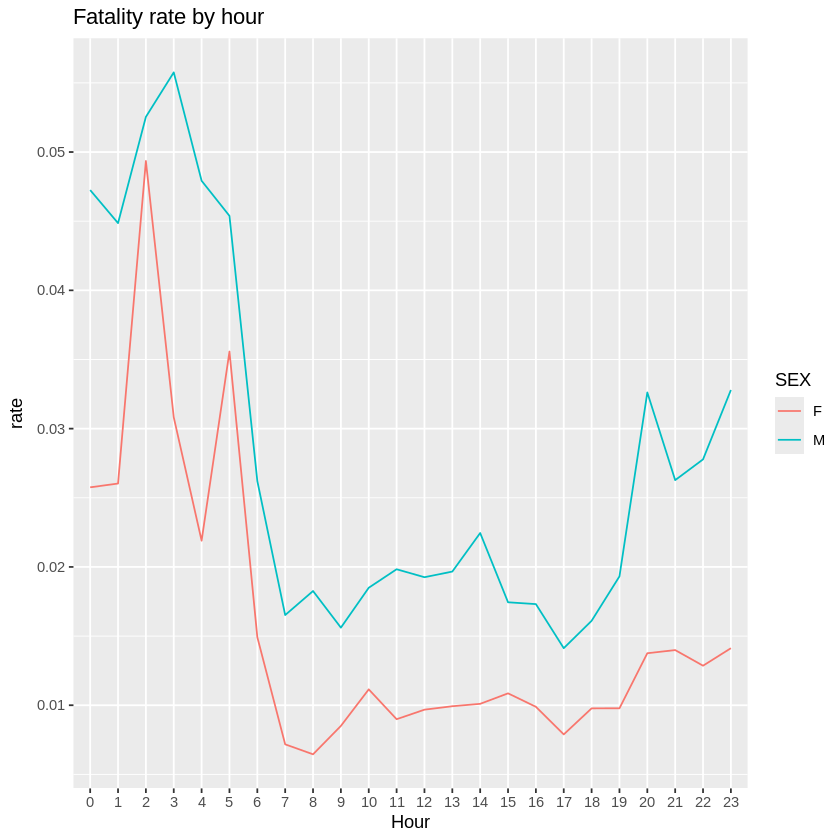

In [ ]:
#Fatality rate by hour and sex
fat_hour <- vicDataPre %>%
  group_by(hour_fac, SEX) %>%
  summarise(rate = mean(fatal_cnt), .groups = "drop")  # compute average fatality rate

ggplot(fat_hour %>% filter(SEX != "U")) +
  geom_line(aes(x = hour_fac, y = rate, group = SEX, colour = SEX)) +
  labs(title = "Fatality rate by hour", x = "Hour")

#Fatality rate helmet/belt use
vicDataPre %>%
  group_by(HELMET_BELT_WORN) %>%
  summarise(rate = mean(fatal_cnt), .groups = "drop")  # summarise by helmet/belt use


**Try this:** Create a similar plot showing fatality rate by `AGE_GROUP` or `SPEED_ZONE`.


---

## 4. Train/Test split

We split the data into training and testing sets (80/20 split). Always set a seed for reproducibility.


In [ ]:
set.seed(123)
n <- nrow(vicDataPre)
indexTrain <- sample(1:n, round(n * 0.8))

vicDataTrain <- vicDataPre[indexTrain, ]
vicDataTest <- vicDataPre[-indexTrain, ]

---

## 5. Logistic regression

We fit a simple logistic regression model using key features. We then plot the coefficient estimates for each hour.



Call:
glm(formula = fatal_cnt ~ SEX + AGE_GROUP + HELMET_BELT_WORN + 
    Weekday + hour_fac, family = binomial(), data = vicDataTrain)

Coefficients:
                                    Estimate Std. Error z value Pr(>|z|)    
(Intercept)                       -3.4885057  0.2509455 -13.901  < 2e-16 ***
SEXM                               0.6705898  0.0455106  14.735  < 2e-16 ***
SEXU                              -0.3836572  0.7115944  -0.539 0.589782    
AGE_GROUP18-21                    -0.3064205  0.2224206  -1.378 0.168308    
AGE_GROUP22-25                    -0.4977432  0.2244623  -2.217 0.026590 *  
AGE_GROUP26-29                    -0.2727769  0.2241879  -1.217 0.223706    
AGE_GROUP30-39                    -0.2951077  0.2200823  -1.341 0.179954    
AGE_GROUP40-49                    -0.2673701  0.2212096  -1.209 0.226788    
AGE_GROUP50-59                    -0.0082201  0.2215421  -0.037 0.970402    
AGE_GROUP60-64                     0.0170079  0.2310682   0.074 0.941324    
A

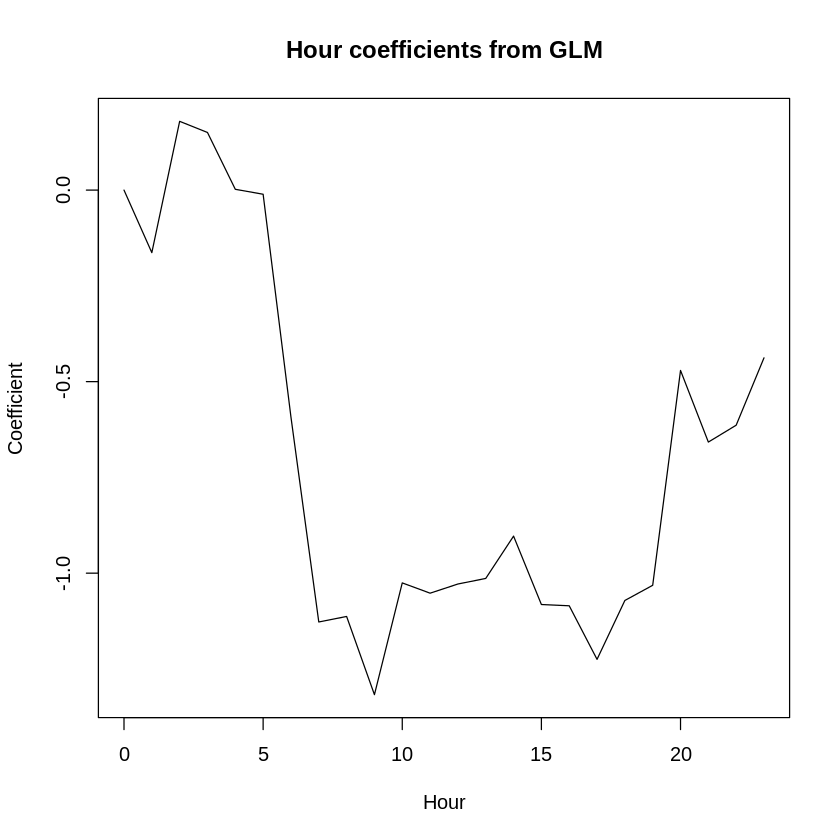

In [ ]:
glmSimple <- glm(fatal_cnt ~ SEX + AGE_GROUP + HELMET_BELT_WORN +
                   Weekday + hour_fac, family = binomial(),
                 data = vicDataTrain)
summary(glmSimple)

coef_glm <- glmSimple$coefficients
hour_coef <- c(0, coef_glm[grep("^hour_fac", names(coef_glm))])

plot(0:23, hour_coef, type = "l", xlab = "Hour", ylab = "Coefficient",
     main = "Hour coefficients from GLM")



**Interpretation:** The `hour_fac` coefficients show how the odds of a fatal crash vary throughout the day.

---

## 6. ROC and AUC for GLM

To evaluate the performance of the simple logistic regression model, we use the Receiver Operating Characteristic (ROC) curve and calculate the Area Under the Curve (AUC). The ROC curve plots the true positive rate (sensitivity) against the false positive rate (1-specificity) at various probability thresholds. The AUC provides a single scalar measure of the model's ability to distinguish between the positive and negative classes (fatal and non-fatal crashes). A higher AUC indicates better discriminatory power.

First we need to obtain the predicted probabilities of an accident from the GLM.

Setting levels: control = 0, case = 1

Setting direction: controls < cases



Area under the curve: 0.6498

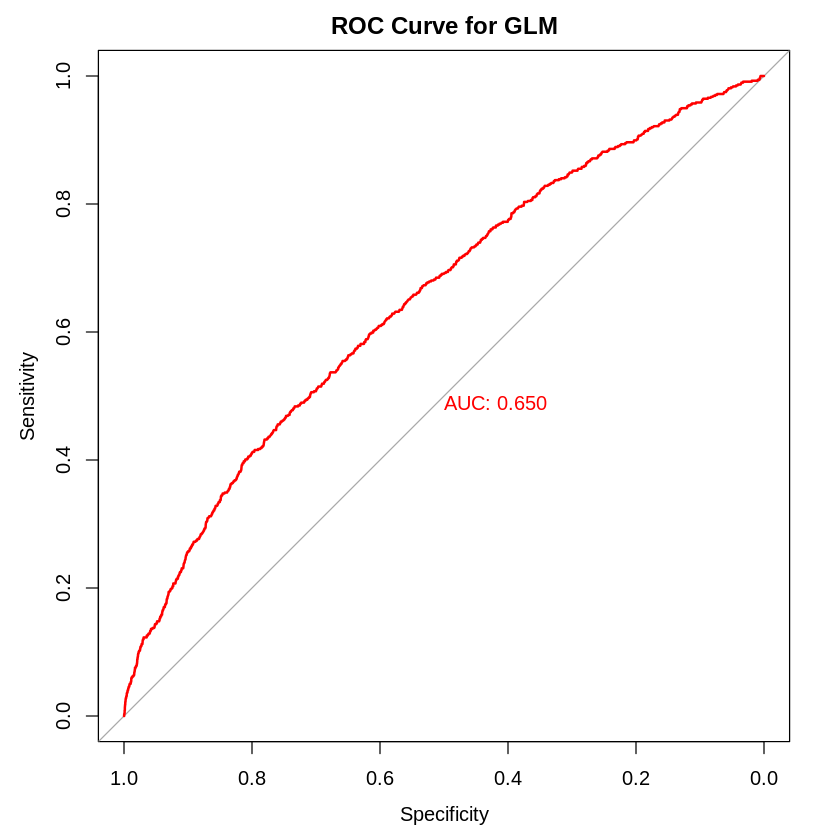

In [ ]:
predTest <- data.frame(glm = predict(glmSimple, newdata = vicDataTest,
                                     type = "response")) # predicted probabilities

ROC_test_glm <- roc(vicDataTest$fatal_cnt, predTest$glm)
plot(ROC_test_glm, col = "red", main = "ROC Curve for GLM", print.auc = TRUE)
auc(ROC_test_glm)

**Question:** What does an AUC of 0.5 mean? What about 1.0?

---

## 7. Lasso logistic regression

Lasso (Least Absolute Shrinkage and Selection Operator) is a regularisation technique that can improve the performance and interpretability of linear models, including logistic regression, by shrinking some coefficient estimates towards zero and potentially setting others exactly to zero. This performs automatic variable selection and helps prevent overfitting. We use the `glmnet` package, which requires the input data to be in the form of a model matrix, which we create using `model.matrix`.

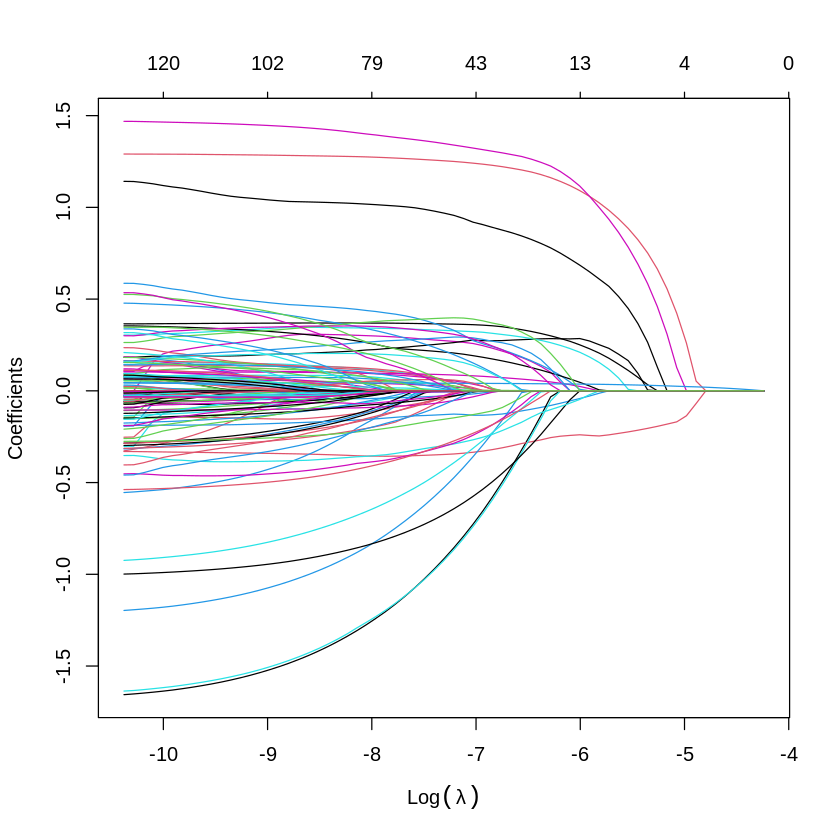

In [ ]:
X <- model.matrix(fatal_cnt ~ ., data = vicDataTrain)[, -1]  # drop intercept
Y <- vicDataTrain$fatal_cnt

lasso <- glmnet(X, Y, alpha = 1, family = "binomial")  # alpha=1 for lasso
plot(lasso, xvar = "lambda")  # show shrinkage path of coefficients

To find the optimal amount of regularisation (controlled by the hyperparameter $\lambda$), we use cross-validation with `cv.glmnet`. Cross-validation involves splitting the training data into multiple folds, training the model on a subset of the folds, and evaluating it on the remaining fold. This process is repeated for different values of $\lambda$, and the $\lambda$ that results in the best performance (in this case, measured by AUC) is selected. Due to the large dataset size, we use 5 folds for cross-validation.

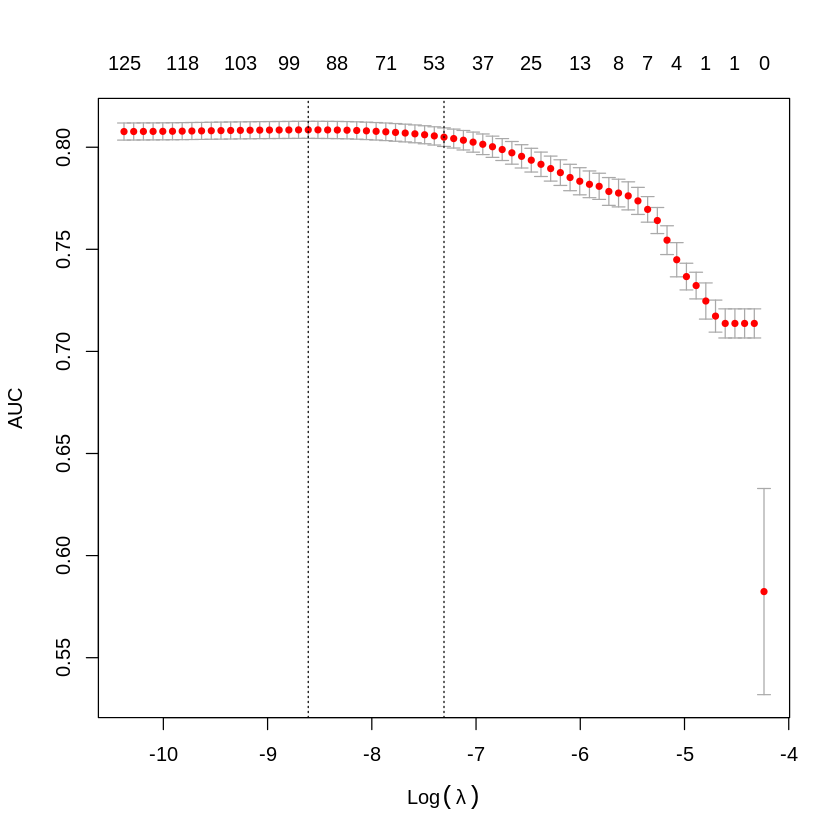

In [ ]:
set.seed(2)
cv.lasso <- cv.glmnet(X, Y, alpha = 1, family = "binomial", nfolds = 5, type.measure = "auc")  # cross-validation
plot(cv.lasso)
best_lambda <- cv.lasso$lambda.min  # lambda that gives best AUC

lassoModel <- glmnet(X, Y, alpha = 1, family = "binomial", lambda = best_lambda)  # final model

**Comment:** Lasso automatically shrinks some coefficients to 0. This can help reduce overfitting.

**Practice:** Which variables are retained in the final Lasso model? Use `coef(lassoModel)` to inspect.

We now evaluate the performance of the Lasso logistic regression model on the test set using the ROC curve and AUC, similar to how we evaluated the simple GLM. We expect the Lasso model to potentially perform better due to its regularisation and variable selection capabilities.

Setting levels: control = 0, case = 1

Setting direction: controls < cases



Area under the curve: 0.7996

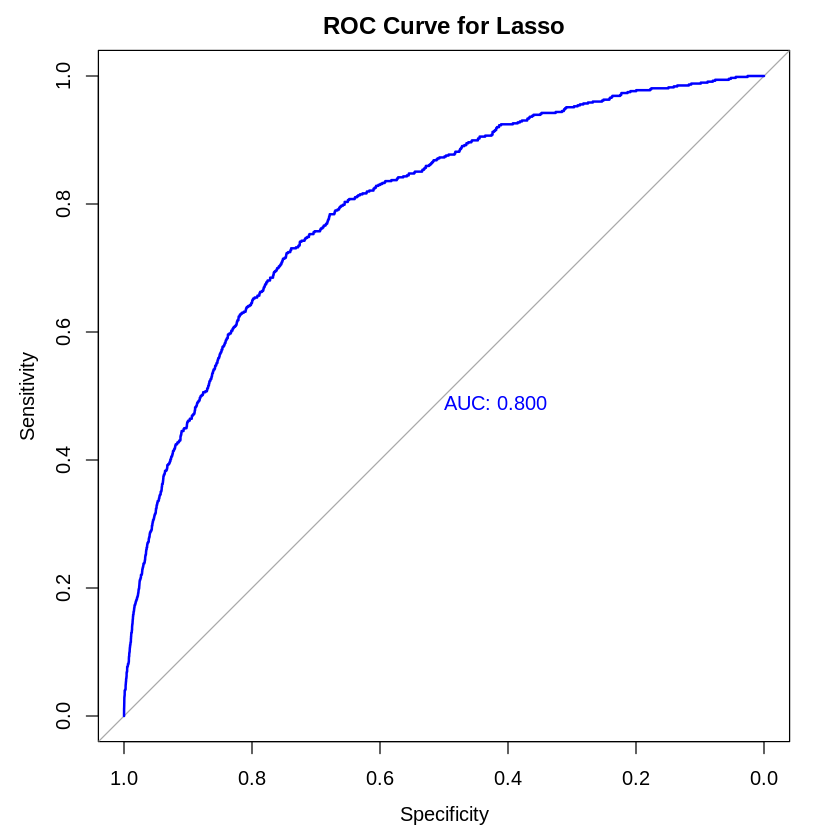

In [ ]:
newX <- model.matrix(fatal_cnt ~ ., data = vicDataTest)[, -1]
predTest$lasso <- predict(lassoModel, newx = newX, type = "response")

ROC_test_lasso <- roc(vicDataTest$fatal_cnt, as.numeric(predTest$lasso))
plot(ROC_test_lasso, col = "blue", main = "ROC Curve for Lasso", print.auc = TRUE)
auc(ROC_test_lasso)

**Question:** Is this model better than the simple GLM from before?

---

## 8. Decision tree

We fit a simple classification tree using the `rpart` package. Decision trees are non-linear models that partition the feature space into rectangular regions and assign a class label to each region. The `rpart.control` function is used to control the tree growing process:
- `minsplit`: The minimum number of observations that must exist in a node in order for a split to be attempted.
- `maxdepth`: The maximum depth of any node in the final tree, with the root node counted as depth 0.
- `minbucket`: The minimum number of observations in any terminal node (leaf). If a split creates a child node with fewer than `minbucket` observations, that split is not allowed.
- `cp`: The complexity parameter. Any split that does not decrease the overall lack of fit by a factor of `cp` is not attempted. Setting `cp = -1` disables pruning based on complexity during the initial tree growing phase, allowing the tree to grow to its maximum possible size given the other control parameters.

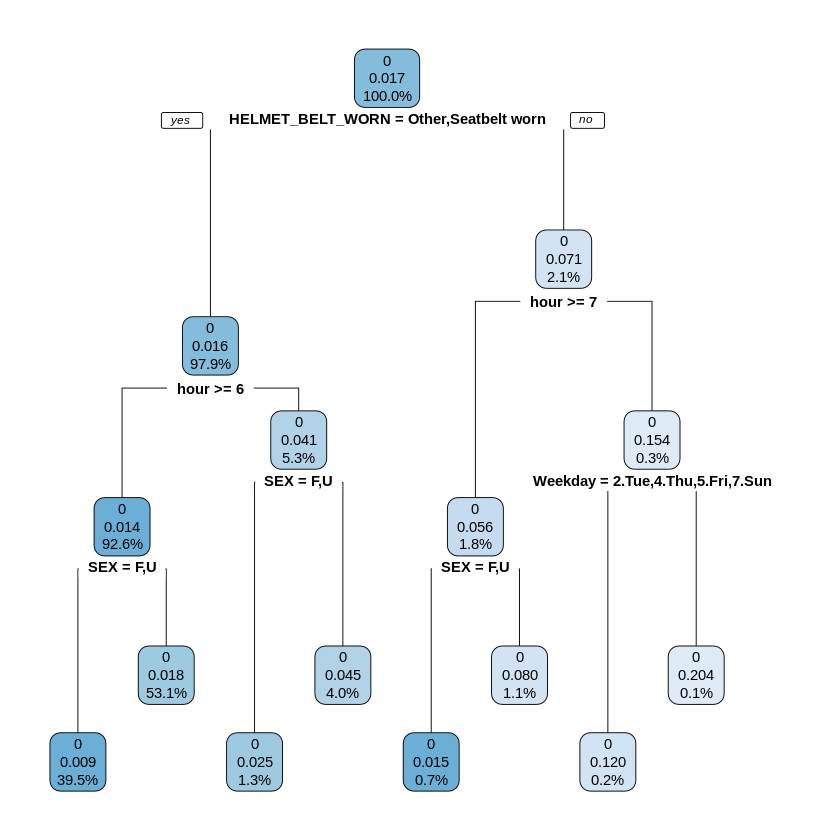

In [ ]:
control <- rpart.control(minsplit = 10, # Minimum number of observations in a node for a split to be attempted
                         maxdepth = 3, # Maximum depth of the tree
                         minbucket = 100, # Minimum number of observations in any terminal node
                         cp = -1) # Complexity parameter (set to -1 to disable pruning based on complexity)
rpartModel <- rpart(fatal_cnt ~ SEX + AGE + HELMET_BELT_WORN +
                      Weekday + hour, data = vicDataTrain, method = "class",
                    control = control)  # fit tree classifier

rpart.plot(rpartModel, type = 2, digits = 3)  # visualise the tree

Now that we have trained the decision tree model, we need to make predictions on the test set to evaluate its performance. We will use the `predict` function with `type = "prob"` to get the predicted probabilities of a fatal crash for each observation in the test set. We will then store these probabilities in a new column named `tree` in the `predTest` data frame.

With this, we evaluate the model using ROC curves and the AUC, similar to the previous models.

Setting levels: control = 0, case = 1

Setting direction: controls < cases



Area under the curve: 0.6099

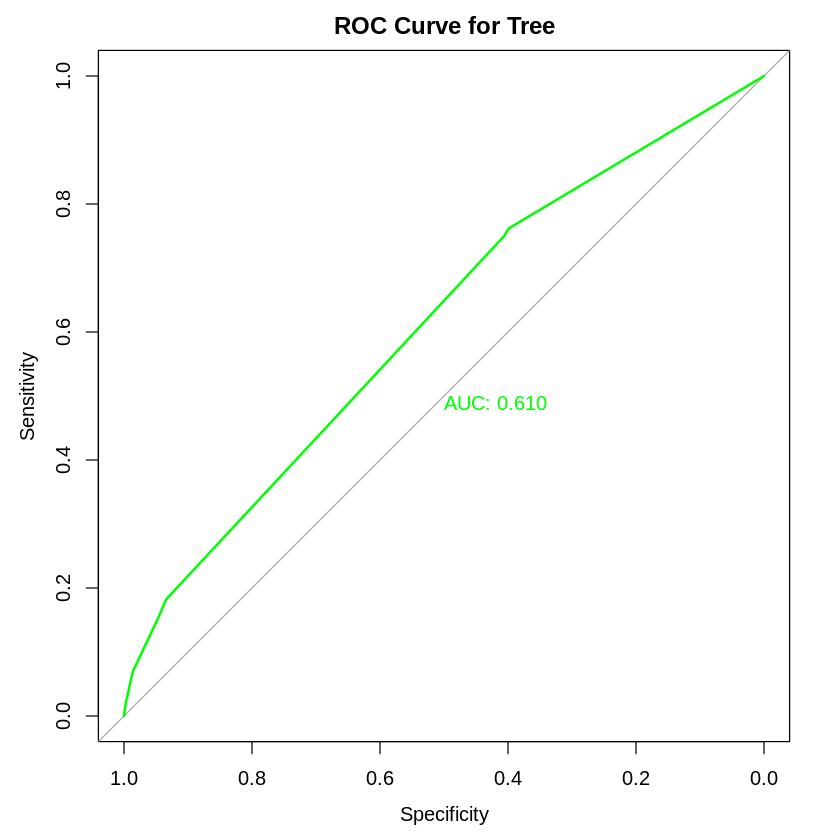

In [ ]:
predTestTree <- predict(rpartModel, newdata = vicDataTest, type = "prob")
predTest$tree <- predTestTree[, 2]

ROC_test_tree <- roc(vicDataTest$fatal_cnt, predTest$tree)
plot(ROC_test_tree, col = "green", main = "ROC Curve for Tree", print.auc = TRUE)
auc(ROC_test_tree)

**Note:** Trees are easy to explain but may underperform in predictive accuracy.

**Try this:** Increase `maxdepth` to 5 or 6. How does AUC change?

---

## 9. Compare models
Finally, we compare the performance of the three models (Simple GLM, Lasso GLM, and Decision Tree) on the test data by examining their ROC curves and calculating their respective AUC values. A higher AUC indicates a better-performing model in terms of its ability to discriminate between fatal and non-fatal crashes.

,Model,AUC
,<chr>,<dbl>
GLM,GLM,0.6497840
Lasso,Lasso,0.7995964
Tree,Tree,0.6099287


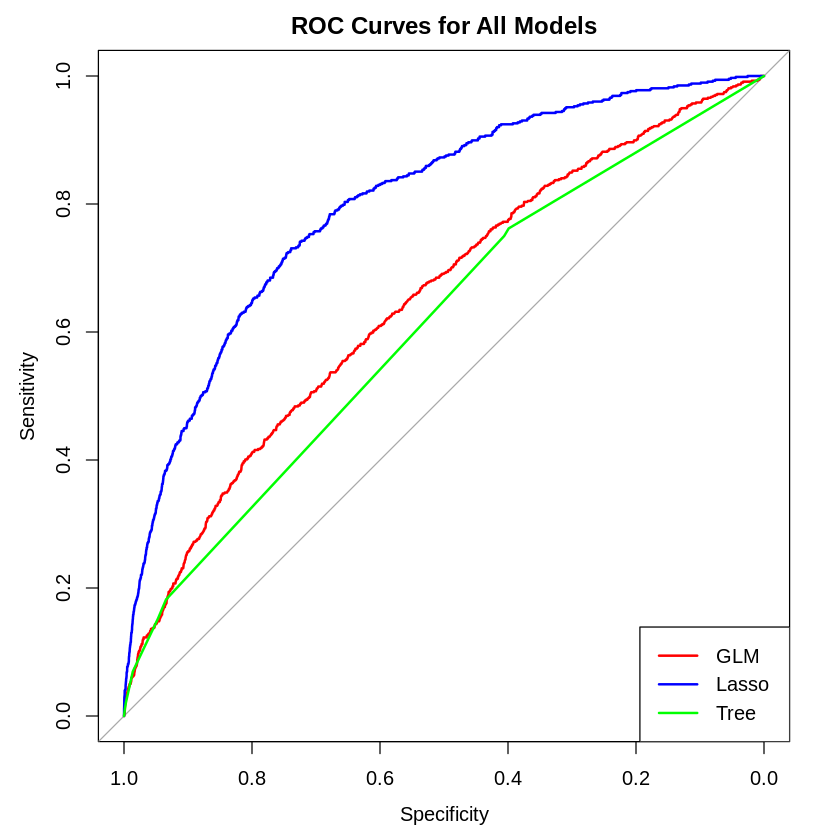

In [ ]:
roc_list <- list(GLM = ROC_test_glm, Lasso = ROC_test_lasso, Tree = ROC_test_tree)
roc_df <- data.frame(
  Model = names(roc_list),
  AUC = sapply(roc_list, auc)
)
roc_df

plot(roc_list$GLM, col = "red", main = "ROC Curves for All Models")
plot(roc_list$Lasso, col = "blue", add = TRUE)
plot(roc_list$Tree, col = "green", add = TRUE)
legend("bottomright", legend = names(roc_list), col = c("red", "blue", "green"), lwd = 2)